Проведите парсинг сайта https://structura.app/. Получите название каждой статьи. Создайте пары: название статьи и ее содержимое, проанализируйте длины получившихся чанков в токенах, при необходимости поделите чанки на более короткие любым подходящим сплиттером, в итоге у всех чанков должно быть название как в метаданных, так и в тексте самого чанка. Сделайте на основе получившихся документов нейро-консультанта. Проработайте промпт в system и user самостоятельно. По возможности примените методы экономии токенов.

In [ ]:
!pip install nest_asyncio xmltodict openai==0.28.0 langchain==0.0.281 tiktoken faiss-cpu lxml bs4 html5lib

In [ ]:
import nest_asyncio
nest_asyncio.apply()
import xmltodict
from langchain.document_loaders.sitemap import SitemapLoader
import requests
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
import tiktoken
import matplotlib.pyplot as plt
import getpass
import os
import openai
from langchain.vectorstores import FAISS
import re
from bs4 import BeautifulSoup
from langchain.chat_models import ChatOpenAI
from langchain.chains import create_extraction_chain
import pickle
from langchain.schema import Document

In [ ]:
openai_key = getpass.getpass("OpenAI API Key:")
os.environ["OPENAI_API_KEY"] = openai_key
openai.api_key = openai_key

OpenAI API Key:··········


In [ ]:
# производим парсинг сайта при помощи SitemapLoader
url = "https://structura.app/"
url_site_map = f"{url}/sitemap.xml"

sitemap_loader = SitemapLoader(web_path=url_site_map)
url_site_map

'https://structura.app//sitemap.xml'

In [ ]:
# Получаем список docs - по одному документу на страничку сайта
docs = sitemap_loader.load()

Fetching pages: 100%|##########| 50/50 [00:11<00:00,  4.19it/s]


In [ ]:
# Общее количество страниц
len(docs)

50

In [ ]:
# Посмотрим на первые несколько чанков
docs[:2]

[Document(page_content='Structura — онлайн конструктор прототипов, схем и макетов для вашего сайтаГлавнаяКак работает краулерТарифыБлогКак работает краулерТарифыБлогНачать бесплатноСоздай прототип сайтаза 10 минутМощный онлайн инструмент проектирования ускорит работу на этапе предпроекта на 80%ПопробоватьБесплатно и навсегда, привязывать карту не нужноДизайнерМенеджерВладелец продуктаКак работает сервис Structura.appПродуманная структура — основа лучшего UXРассказ о сервисе за 4 минуты|При разработке сайта, важно уметь смотреть глазами пользователя. Именно поэтому начинать нужно с грамотной структуры посадочных страниц и анализа своих конкурентов.Плохая проработка на этапе предпроекта приводит к большим временным и финансовым вложениям, бесконечным согласованиям и доработкам.Мы скомпилировали опыт всей веб-индустрии, чтобы вы могли создавать лучшие сайты!Попробовать бесплатноУзнать больше о насТри способа создать прототип сайта с помощью Structura.appВыбирай любой 😁На основе сайтаПринц

Мы получили текстовое содержимое всех страниц сайта. Давайте проведем эксперимент. Попробуем при помощи create_extraction_chain извлечь пару: название статьи и ее содержимое. Таким образом, у нас получатся более структурированные и логичные чанки. К тому же, на некоторых страничках содержатся несколько статей, таким образом, мы разделим текст со странички на логические блоки.

In [ ]:
# инициализируем модель
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-16k-0613")

In [ ]:
#  Применяем create_extraction_chain для извлечения названия статьи и ее содержимого в формате строки
schema = {
    "properties": {
        "article_title": {"type": "string"},
        "article_content": {"type": "string"}
    },
    "required": ["article_title", "article_content"]
}

def extract(content: str, schema: dict):
    return create_extraction_chain(schema=schema, llm=llm).run(content)

In [ ]:
%%time
# Применяем функцию extract ко всем документам
extracted_data_all = []

for doc in docs:
    content = doc.page_content

    # Применяем функцию extract
    extracted_content = extract(content=content, schema=schema)

    # Добавляем извлеченные данные в список (если нужно)
    extracted_data_all.append(extracted_content)

In [ ]:
j = -1
extracted_data_all_1 = []
err_docs = []

In [ ]:
# Обработчик ошибок
for i, doc in enumerate(docs):
    if i > j:
      content = doc.page_content
      try:
        extracted_content = extract(content=content, schema=schema)
        extracted_data_all_1.append(extracted_content)
        j = i
        print('Обработана страница', i)
      except:
        print('Ошибка обработки страницы', i)
        err_docs.append(i)

Обработана страница 0
Обработана страница 1
Обработана страница 2
Обработана страница 3
Обработана страница 4
Обработана страница 5
Обработана страница 6
Обработана страница 7
Обработана страница 8
Обработана страница 9
Обработана страница 10
Обработана страница 11
Обработана страница 12
Обработана страница 13
Обработана страница 14
Ошибка обработки страницы 15
Обработана страница 16
Обработана страница 17
Обработана страница 18
Обработана страница 19
Обработана страница 20
Обработана страница 21
Ошибка обработки страницы 22
Ошибка обработки страницы 23
Обработана страница 24
Ошибка обработки страницы 25
Ошибка обработки страницы 26


In [ ]:
# Загрузим файл предоставленный Светланой
from google.colab import files
uploaded = files.upload()

# читаем файл
import io
import pickle

file_name = "my_list.pkl"
extracted_data_all = pickle.load(io.BytesIO(uploaded[file_name]))

Saving my_list.pkl to my_list.pkl


In [ ]:
# Вся база знаний, состоящая из названий статей и их текстов
extracted_data_all[:2]

[[{'article_title': 'Structura — онлайн конструктор прототипов, схем и макетов для вашего сайта',
   'article_content': 'Главная\nКак работает краулер\nТарифы\nБлог\nКак работает краулер\nТарифы\nБлог\nНачать бесплатно\nСоздай прототип сайта\nза 10 минут\nМощный онлайн инструмент проектирования ускорит работу на этапе предпроекта на 80%\nПопробовать\nБесплатно и навсегда, привязывать карту не нужно\nДизайнер\nМенеджер\nВладелец продукта\nКак работает сервис Structura.app\nПродуманная структура — основа лучшего UX\nРассказ о сервисе за 4 минуты|\nПри разработке сайта, важно уметь смотреть глазами пользователя. Именно поэтому начинать нужно с грамотной структуры посадочных страниц и анализа своих конкурентов.\nПлохая проработка на этапе предпроекта приводит к большим временным и финансовым вложениям, бесконечным согласованиям и доработкам.\nМы скомпилировали опыт всей веб-индустрии, чтобы вы могли создавать лучшие сайты!\nПопробовать бесплатно\nУзнать больше о нас\nТри способа создать пр

In [ ]:
# некоторые странички содержат несколько статей:
extracted_data_all[6]

[{'article_title': 'Почему на моем сайте нет карты сайта',
  'article_content': 'Создавать карту сайта или нет — это, на самом деле, очень спорный вопрос. Часть оптимизаторов не представляет себе жизни без карты и яростно отстаивает необходимость в ней, другие — молча делают сайты без неё. А результаты, при этом, есть и у тех, и у других. Где же правда? Еще материалы на тему сайтмапов: Зачем визуализировать сайтмапы Добавлять ли сайтмап в нижнюю часть сайта Анализ карты сайта при конкурентной разведке Как часто нужно обновлять карту сайта Сайтмап для лендинга'},
 {'article_title': 'Поисковые машины и сайтмап',
  'article_content': 'Для начала, выложим факты на стол: Нигде, ни в одном материале, ни в одной инструкции для вебмастеров у Яндекса или Google не написано, что сайт не будет индексироваться без карты. Да, поисковики дают свои рекомендации по поводу сайтмапа, но они слишком размыты и неконкретны. Например, у Google: «Наличие файла Sitemap не гарантирует сканирование и индексацию

Теперь соберем все наши статьи и их названия в Langchain document, где в page_content у нас будет содержаться название статьи и сама статья, а в metadata каждого чанка будет передаваться только название статьи:

In [ ]:
# Создаем список Langchain documents
documents = []

for item in extracted_data_all:
    # Итерируемся по каждому словарю в списке элемента
    for dictionary in item:
        # в page_content у нас будет содержаться название статьи и сама статья
        page_content = dictionary['article_title'] + '\n' + dictionary['article_content']
        # а в metadata каждого чанка будет передаваться название статьи
        metadata = {
            'article_title': dictionary['article_title']
        }

        document = Document(page_content=page_content, metadata=metadata)
        documents.append(document)

In [ ]:
# выводим один из получившихся документов, чтобы проверить, что все получилось правильно
documents[7]

Document(page_content='Поисковые машины и сайтмап\nДля начала, выложим факты на стол: Нигде, ни в одном материале, ни в одной инструкции для вебмастеров у Яндекса или Google не написано, что сайт не будет индексироваться без карты. Да, поисковики дают свои рекомендации по поводу сайтмапа, но они слишком размыты и неконкретны. Например, у Google: «Наличие файла Sitemap не гарантирует сканирование и индексацию всех страниц, ввиду того что эта процедура выполняется с помощью сложных алгоритмов». Поисковые роботы развиваются уже больше 15 лет – и наличие карты сайта, по исследованиям оптимизаторов, никак не увеличивает количество страниц в выдаче, а, иногда, даже и уменьшает. Условно, было у вас 100.000 страниц, загрузили карту сайта — осталось 80.000 страниц. В общем, роботы уже давно работают по своему, умному и развивающемуся алгоритму, и наличие сайтмапа мало что меняет. Даже на официальном сайте стандарта www.sitemaps.org написано, что карта сайта может помогать в индексации, но никак

Нужно проверить, какой длины чанки у нас содержатся в нашей БЗ

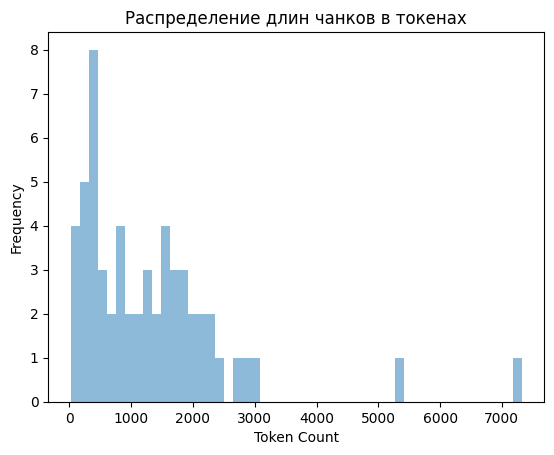

In [ ]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

# Подсчет токенов для каждого фрагмента и построение графика
fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in documents]
plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
plt.title('Распределение длин чанков в токенах')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

Видим, что некоторые чанки достаточно большие, нужно их разделить на более мелкие, также, чтобы при разделении чанков на более мелкие не потерялось название статьи, его мы тоже добавим.

In [ ]:
# Создаем пустой список для хранения фрагментов
docs_final = []

# Пороговое значение для количества токенов
threshold = 2000

# Перебираем каждый фрагмент
for fragment in documents:
    num_tokens = num_tokens_from_string(fragment.page_content, "cl100k_base")

    # Сохраняем название статьи из метаданных
    article_title = fragment.metadata['article_title']

    # Если фрагмент превышает пороговое значение, разбиваем его
    if num_tokens > threshold:
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)
        text_parts = text_splitter.split_text(fragment.page_content)

        for i, text_part in enumerate(text_parts):
            # Добавляем название статьи только ко второй и последующим частям, так как в первой он уже содержится
            if i == 0:
                docs_final.append(Document(
                    page_content=text_part,
                    metadata={'article_title': article_title}
                ))
            else:
                docs_final.append(Document(
                    page_content=article_title + '\n' + text_part,
                    metadata={'article_title': article_title}
                ))
    else:
        # Если фрагмент не превышает порог, добавляем его как есть
        docs_final.append(fragment)

In [ ]:
# всего получилось чанков:
len(docs_final)

104

In [ ]:
docs_final[:2]

[Document(page_content='Structura — онлайн конструктор прототипов, схем и макетов для вашего сайта\nГлавная\nКак работает краулер\nТарифы\nБлог\nКак работает краулер\nТарифы\nБлог\nНачать бесплатно\nСоздай прототип сайта\nза 10 минут\nМощный онлайн инструмент проектирования ускорит работу на этапе предпроекта на 80%\nПопробовать\nБесплатно и навсегда, привязывать карту не нужно\nДизайнер\nМенеджер\nВладелец продукта\nКак работает сервис Structura.app\nПродуманная структура — основа лучшего UX\nРассказ о сервисе за 4 минуты|\nПри разработке сайта, важно уметь смотреть глазами пользователя. Именно поэтому начинать нужно с грамотной структуры посадочных страниц и анализа своих конкурентов.\nПлохая проработка на этапе предпроекта приводит к большим временным и финансовым вложениям, бесконечным согласованиям и доработкам.\nМы скомпилировали опыт всей веб-индустрии, чтобы вы могли создавать лучшие сайты!\nПопробовать бесплатно\nУзнать больше о нас\nТри способа создать прототип сайта с помощь

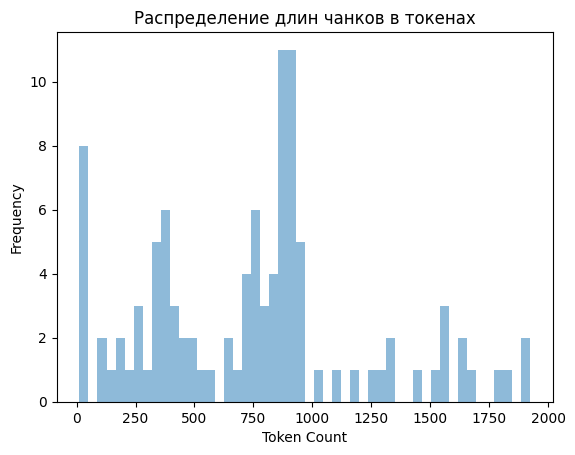

In [ ]:
# Проверяем, что больше нет чанков, превышающих 2000 токенов
def num_tokens_from_string_2(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

# Подсчет токенов для каждого фрагмента и построение графика
fragment_token_counts = [num_tokens_from_string_2(fragment.page_content, "cl100k_base") for fragment in docs_final]
plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
plt.title('Распределение длин чанков в токенах')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(docs_final, embeddings)

In [ ]:
# Функция для загрузки документа по ссылке из Google Drive
def load_document_text(url: str) -> str:
    # Извлечение идентификатора документа из URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Загружаем документ в виде обычного текста
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [ ]:
system=load_document_text("https://docs.google.com/document/d/1tZ2vowvO6zRn_2s_y1rIDxKqj-ZI5wwEbcPvJ7mfG6Y/edit?usp=sharing")

In [ ]:
def answer_index(system, topic, search_index, temp=0, verbose=0) -> str:
    """Функция возвращает ответ модели на основе заданной темы."""
    # находим наиболее релевантные вопросу пользователя чанки:
    docs = search_index.similarity_search(topic, k=3)
    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)]))

    # если параметр verbose=1, то выводим релевантные чанки
    if verbose:
        print('message_content :\n', message_content)

    messages = [
        {"role": "system", "content": system},
        # в user промпт пишем на английском - для экономии токенов
        {"role": "user", "content": f"Answer the user's question. Document with information for the user's answer: {message_content}\n\n User's question: \n{topic}"}
    ]

    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=temp
    )

    return completion.choices[0].message.content

In [ ]:
topic="Как сделать сайт если я неумею программировать?"                                                                          # укажите необходимое значение
ans=answer_index(system, topic, db, temp=0, verbose=0)
ans

'Согласно информации из документа, если вы не умеете программировать, есть несколько способов создать сайт. Один из способов - использовать неспециализированный сервис, такой как Яндекс Бизнес, Google Мой бизнес или Zoon, которые предлагают функцию создания сайта внутри своей платформы. Однако, у этих конструкторов может быть ограниченный функционал и они больше ориентированы на увеличение вашего присутствия в их экосистеме. Если у вас небольшой ассортимент товаров или услуг и вам важен трафик с карт, то этот вариант может подойти для вас. Также стоит упомянуть, что в этих сервисах обычно не требуется помощь фрилансеров, так как они предлагают простой и быстрый способ создания сайта самостоятельно.'

In [ ]:
topic="Сколько сайтов я могу создать бесплатно на твоем ресурсе?"                                                                          # укажите необходимое значение
ans=answer_index(system, topic, db, temp=0, verbose=0)
ans

'На ресурсе Structura.App вы можете создать один сайт бесплатно.'

In [ ]:
topic="Какое максимальное количество страниц может быть у одного сайта?"                                                                          # укажите необходимое значение
ans=answer_index(system, topic, db, temp=0, verbose=0)
ans

'Максимальное количество страниц на одном сайте зависит от различных факторов, таких как тип сайта, его цель и структура. В документе, который мне предоставили, нет конкретной информации о максимальном количестве страниц. Поэтому я не могу дать точный ответ на ваш вопрос.'